<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [225]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [226]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.12.0 / PyTorch 2.5.0+cu121


# Dataloader


In [227]:
BATCH_SIZE = 32
NUM_CLIENTS = 10

In [228]:
def load_datasets(partition_id: int, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


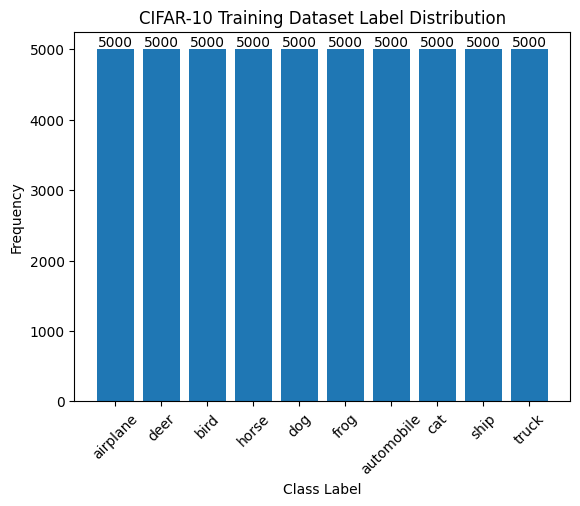

In [229]:
# Download the CIFAR-10 dataset
logging.set_verbosity_error()  # Suppress logs at the error level and below
cifar10 = load_dataset("cifar10")

# Construct histogram for training labels
all_labels = cifar10["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# Plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()],
               labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
               rotation=45)

plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("CIFAR-10 Training Dataset Label Distribution")
plt.show()


# Model

In [230]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [231]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 62006


## Bigger CNN model

In [232]:
class CNNModel_2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel_2, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)

        # Second block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.5)

        # Third block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Output size from conv layers after 3 pooling layers (32x32 -> 4x4)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Fully connected layers
        x = x.view(-1, 128 * 4 * 4)  # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x)  # No activation, handled by loss function

        return x


In [233]:
model_2 = CNNModel_2()
num_parameters = sum(value.numel() for value in model_2.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 552881


# train test Func


In [234]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## set-get params


In [235]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## FlowerClient

In [236]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [237]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [238]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [239]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    return loss, {"server_round": server_round, "accuracy": accuracy, "loss": loss}

In [240]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [241]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 2 ,
    }
    return config

In [242]:
NUM_CLIENTS = 10

In [243]:
strategy_3 = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(get_parameters(net)),
    )

In [244]:
NUM_ROUNDS = 10

In [245]:
params = get_parameters(Net())

In [246]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [247]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07210922555923462, {'accuracy': 0.0982}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07210922555923462 / accuracy 0.0982


(pid=48960) 2024-11-15 18:41:01.515835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=48960) 2024-11-15 18:41:01.558605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=48960) 2024-11-15 18:41:01.570210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=48960) 2024-11-15 18:41:04.106728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=48960) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor 

(ClientAppActor pid=48960) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 2}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.06297311744689942, {'accuracy': 0.2834}, 107.09619879100137)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06297311744689942 / accuracy 0.2834
(ClientAppActor pid=48960) [Client 5] evaluate, config: {}
(ClientAppActor pid=48959) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48960) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.2868 0.0 
(ClientAppActor pid=48960) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.05204924219846725, {'accuracy': 0.3892}, 209.50376697000138)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05204924219846725 / accuracy 0.3892
(ClientAppActor pid=48960) [Client 0] evaluate, config: {}
(ClientAppActor pid=48959) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 1] evaluate, config: {}
(ClientAppActor pid=48959) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48960) [Client 7] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.38489999999999996 0.0 
(ClientAppActor pid=48960) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48959) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.04759984501600265, {'accuracy': 0.4435}, 309.8562948630006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04759984501600265 / accuracy 0.4435
(ClientAppActor pid=48960) [Client 1] evaluate, config: {}
(ClientAppActor pid=48960) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48960) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4438 0.0 
(ClientAppActor pid=48960) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 0] evaluate, config: {}
(ClientAppActor pid=48960) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.04490394594669342, {'accuracy': 0.4759}, 410.28744304500105)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04490394594669342 / accuracy 0.4759
(ClientAppActor pid=48960) [Client 1] evaluate, config: {}
(ClientAppActor pid=48959) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48959) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4746 0.0 
(ClientAppActor pid=48959) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.04288207731842995, {'accuracy': 0.5028}, 506.5189026240005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04288207731842995 / accuracy 0.5028
(ClientAppActor pid=48960) [Client 1] evaluate, config: {}
(ClientAppActor pid=48959) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48959) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48960) [Client 7] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5069000000000001 0.0 
(ClientAppActor pid=48960) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 9, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.041826196527481076, {'accuracy': 0.5189}, 616.8792960190003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.041826196527481076 / accuracy 0.5189
(ClientAppActor pid=48959) [Client 0] evaluate, config: {}
(ClientAppActor pid=48959) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48959) [Client 7] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5223000000000001 0.0 
(ClientAppActor pid=48959) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.04003206954002381, {'accuracy': 0.5369}, 724.7473431800008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.04003206954002381 / accuracy 0.5369
(ClientAppActor pid=48959) [Client 0] evaluate, config: {}
(ClientAppActor pid=48959) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48959) [Client 9] evaluate, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5471 0.0 
(ClientAppActor pid=48960) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.03918465572595596, {'accuracy': 0.5522}, 825.61686113)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03918465572595596 / accuracy 0.5522
(ClientAppActor pid=48959) [Client 0] evaluate, config: {}
(ClientAppActor pid=48959) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48960) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.552 0.0 
(ClientAppActor pid=48959) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 1] evaluate, config: {}
(ClientAppActor pid=48959) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.03836849543452263, {'accuracy': 0.5599}, 929.430106965001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03836849543452263 / accuracy 0.5599
(ClientAppActor pid=48960) [Client 2] evaluate, config: {}
(ClientAppActor pid=48960) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48959) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5617 0.0 
(ClientAppActor pid=48960) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(ClientAppActor pid=48960) [Client 0] evaluate, config: {}
(ClientAppActor pid=48959) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48959) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(ClientAppActor pid=48960) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.03726562157869339, {'accuracy': 0.5753}, 1027.1869209819997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03726562157869339 / accuracy 0.5753
(ClientAppActor pid=48960) [Client 2] evaluate, config: {}
(ClientAppActor pid=48959) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(ClientAppActor pid=48959) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48959) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1042.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06441459565162659
INFO :      		round 2: 0.05353822475671768
INFO :      		round 3: 0.049111532616615286
INFO :      		round 4: 0.04626053776144982
INFO :      		round 5: 0.04402207740545273
INFO :      		round 6: 0.04302717933058738
INFO :      		round 7: 0.041120929336547846
INFO :      		round 8: 0.04014484238624573
INFO :      		round 9: 0.03930328649282456
INFO :      		round 10: 0.038182987174391746
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07210922555923462
INFO :      		round 1: 0.06297311744689942
INFO :      		round 2: 0.05204924219846725
INFO :      		round 3: 0.04759984501600265
INFO :      		round 4: 0.04490394594669342
INFO :      		round 5: 0.04288207731842995
INFO :      		round 6: 0.041826196527481076
INFO :      		round 7: 0.0400

My_weighted_average -0.5795 0.0 
(ClientAppActor pid=48960) [Client 9] evaluate, config: {}


(ClientAppActor pid=48959) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=48959) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=48959) see the appropriate new directories, set the environment variable
(ClientAppActor pid=48959) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=48959) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=48959)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


In [248]:
Agregation_history

[{'loss': 0.0, 'accuracy': 0.2868},
 {'loss': 0.0, 'accuracy': 0.38489999999999996},
 {'loss': 0.0, 'accuracy': 0.4438},
 {'loss': 0.0, 'accuracy': 0.4746},
 {'loss': 0.0, 'accuracy': 0.5069000000000001},
 {'loss': 0.0, 'accuracy': 0.5223000000000001},
 {'loss': 0.0, 'accuracy': 0.5471},
 {'loss': 0.0, 'accuracy': 0.552},
 {'loss': 0.0, 'accuracy': 0.5617},
 {'loss': 0.0, 'accuracy': 0.5795}]

In [249]:
evaluation_history

[{'round': 0, 'loss': 0.07210922555923462, 'accuracy': 0.0982},
 {'round': 1, 'loss': 0.06297311744689942, 'accuracy': 0.2834},
 {'round': 2, 'loss': 0.05204924219846725, 'accuracy': 0.3892},
 {'round': 3, 'loss': 0.04759984501600265, 'accuracy': 0.4435},
 {'round': 4, 'loss': 0.04490394594669342, 'accuracy': 0.4759},
 {'round': 5, 'loss': 0.04288207731842995, 'accuracy': 0.5028},
 {'round': 6, 'loss': 0.041826196527481076, 'accuracy': 0.5189},
 {'round': 7, 'loss': 0.04003206954002381, 'accuracy': 0.5369},
 {'round': 8, 'loss': 0.03918465572595596, 'accuracy': 0.5522},
 {'round': 9, 'loss': 0.03836849543452263, 'accuracy': 0.5599},
 {'round': 10, 'loss': 0.03726562157869339, 'accuracy': 0.5753}]

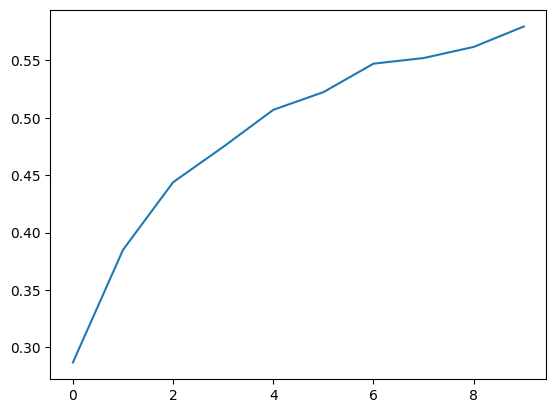

In [250]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

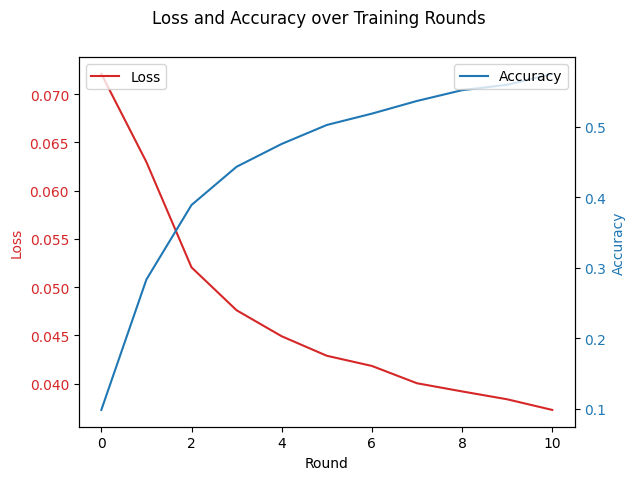

In [251]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
